# Cell Type Joint Distribution  

This notebook evaluates joint distribution of the bipolar subtypes from mouse Retina.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
import pandas as pd
from scipy import interpolate
from scipy.spatial import  ConvexHull


coord_transfer function computes appropriate [center_shift_x , center_shift_y] valuse so that the origin is shifted to the mean of all coordinates and rotatation theta theta_shift so that theta values are continuous between 0 and 2*pi.

In [2]:
def coord_transfer(xcoords, ycoords):
    center_shift_x=np.mean(xcoords)
    center_shift_y=np.mean(ycoords)

    xcoords=xcoords-center_shift_x
    ycoords=ycoords-center_shift_y

    xcoordspi=xcoords>0
    xcoordsni=xcoords<0

    posi=np.argmax(xcoords[xcoordspi]**2+ycoords[xcoordspi]**2)
    negi=np.argmax(xcoords[xcoordsni]**2+ycoords[xcoordsni]**2)


    ymax=ycoords[xcoordspi][posi]
    ymin=ycoords[xcoordsni][negi]
    xmax=xcoords[xcoordspi][posi]
    xmin=xcoords[xcoordsni][negi]

    slope=(ymax-ymin)/(xmax-xmin)
    theta=np.arctan(slope)

    #rotatet the frame so that  first theta does not start from zero, and hence becomes continous
    theta_shift=theta-np.pi/2  
    return [center_shift_x , center_shift_y], theta_shift

coord_translate function translates the input custom coordinates with the valuse obtained by coord_transfer. We actually don't need this function if we intend to compute minimum distances and use shuffling to generate random data. Hovever, this funtion is needed when we use theta bins to compute  joint probability distribution. 

In [3]:

def coord_translate(x, y, shift=0, rtheta=0):
    ##  Parameters:
    
        # xcoords   : array_like Input data X Cartesian Coordinates. 
        # ycoords   : array_like Input data Y Cartesian Coordinates. 

    ##  Returns:
    
        # [center_shift_x , center_shift_y]: The values of the proper coordinate shifts 
        #                                    so that origin is located in the center of the mass.

        # theta_shift  : The value of required rotation so the theta values are continuous.
    
    xo=x-shift[0]
    yo=y-shift[1]

    xr=(np.cos(rtheta)*xo+np.sin(rtheta)*yo)
    yr=(np.cos(rtheta)*yo-np.sin(rtheta)*xo)
    tvalo=np.mod(np.arctan2(yr, xr), 2*np.pi)
    idx_sorted=np.argsort(tvalo)
    tvalo=tvalo[idx_sorted]
    rvalo=np.sqrt(yr**2+xr**2)
    rvalo=rvalo[idx_sorted]

    xsro=xr[idx_sorted]
    ysro=yr[idx_sorted]

    return xsro, ysro, rvalo, tvalo

polar_manifold functions outputs a function that interpolates between theta valuse. Here in this notebook, this function is used to generated high density of coordinate values so that computed volumes for the bins are precise. 

In [4]:
def polar_manifold(r, theta):

    ## Parameters:
    
    # r     : array_like Input data , radius polar coordinates. 
    # theta : array_like Input data, theta polar coordinates. 

    ## Returns:
    
    # ft   : A function that computes radius as a function of theta, it is based on interpolation between theta values. 

    xs=np.sort(theta)
    indt=np.argsort(theta)
    rs=r[indt]
    ft = interpolate.interp1d(xs, rs, fill_value="extrapolate")

    return ft 

joint_probability function computes joint probability of either of the d11=minimum_distance(celltype_1, celltype_1), d12=minimum_distance(celltype_1, celltype_2), d13=minimum_distance(celltype_1, celltype_3) values, or the counts of (celltype_1, celltype_2,celltype_3) inside the input p_bins. Euclidean  distances are used here to compute minimum distances which I suppose can closely approximate the real distances because nearest cell types are most probably close to each other. 

In [5]:
def joint_probability(cpos, Num_NNeigh=1, Num_Bins=20, p_bins=0,svol=1, mode='dist'):

    ## Parameters:
    
        # cpos       : array_like Input data , Cartesian coordinates of the three cell types. 
        # Num_NNeigh : Number of nearest neighbours to compute joint distance probabilities if mode is set to 'dist'
        # Num_Bins   : Number of bins used to compute probabilities.
        # p_bins     : theta bins used to count cell type numbers, used if mode is set to 'bin'
        # svol       : the volume of the bins used to count cell type numbers, used if mode is set to 'bin'
        # mode       : If set to 'dist', it uses minimum distances to estimate joint probability distributions, 
        #              otherwise the cell type locations are divided into bins, and counted in each bin, then normalized 
        #              with bin volumes provided in svol. 

    ## Returns:

        # f3D      : Joint probability distribution of the three input cell type coordinates.   
        # bins     : bins that are used to compute frequency of input values. 
    
    if (mode=='dist'):
        # computing and sorting two by two distances
        crts_dis_11=distance_matrix(cpos[0], cpos[0])
        crts_dis_11=np.sort(crts_dis_11, axis=1)
        crts_dis_12=distance_matrix(cpos[0], cpos[1])
        crts_dis_12=np.sort(crts_dis_12, axis=1)
        crts_dis_13=distance_matrix(cpos[0], cpos[2])
        crts_dis_13=np.sort(crts_dis_13, axis=1)

         # selecting Num_NNeigh distances. cell type 1's zero distance neighbours (the cell itself) are ommited. 
        crts_dis_11_vec=np.concatenate(crts_dis_11[:,1:Num_NNeigh+1])
        crts_dis_12_vec=np.concatenate(crts_dis_12[:,:Num_NNeigh])
        crts_dis_13_vec=np.concatenate(crts_dis_13[:,:Num_NNeigh])
        
        # configuring bins. I've used logarithmic bins here so that there is better resolution for lower distances
        CValmax=np.max(np.concatenate((crts_dis_11_vec, crts_dis_12_vec, crts_dis_13_vec)))
        CValmin=np.min(np.concatenate((crts_dis_11_vec, crts_dis_12_vec, crts_dis_13_vec)))
        bins1 = 10**(np.linspace(np.log10(CValmin), np.log10(CValmax), Num_Bins)) 

        h3D, edges3D = np.histogramdd((crts_dis_12_vec, crts_dis_13_vec, crts_dis_11_vec), bins=[bins1, bins1, bins1])
    else:
        # normalize bin volumes to its maximum valuse. 
        svol=svol/np.max(svol)
        # compute polar coordinates of the input cell positions
        tvec1=np.mod(np.arctan2(cpos[0][:,1], cpos[0][:,0]), 2*np.pi)
        tvec2=np.mod(np.arctan2(cpos[1][:,1], cpos[1][:,0]), 2*np.pi)
        tvec3=np.mod(np.arctan2(cpos[2][:,1], cpos[2][:,0]), 2*np.pi)
        
        # counting the number of cells in each bin
        cnt1vec, edges=np.histogram(tvec1, p_bins)
        cnt2vec, edges=np.histogram(tvec2, p_bins)
        cnt3vec, edges=np.histogram(tvec3, p_bins)
        
        # Normalizing with the bin volumes
        cnt1vec=np.divide(cnt1vec, svol)
        cnt2vec=np.divide(cnt2vec, svol)
        cnt3vec=np.divide(cnt3vec, svol)

        # Configuring the bins for pdf calculation
        cmax=np.max(np.concatenate((cnt1vec, cnt2vec, cnt3vec)))
        cmin=np.min(np.concatenate((cnt1vec, cnt2vec, cnt3vec)))        
        bins1=np.linspace(cmin, cmax, Num_Bins)

        h3D, edges3D = np.histogramdd((cnt2vec, cnt3vec, cnt1vec), bins=[bins1, bins1, bins1])

    return h3D/np.sum(h3D), bins1


plot_distribution function computes marginal distribution functions and plots them. 

In [6]:
def plot_distribution(f3D,pbins, dist_mode='cnt_bin', mode='Real'):
    
    # Parameters:
        # f3D       : Joint probability distribution of the three input cell type coordinates.
        # pbins     : bins that are used to compute frequency of input values.
        # dist_mode :  Used to name axes.
        # mode      :  Used to title the figures.

    # Returns: None
    
    mode=mode+' '
    # marginal pdf of cell type 1, 2, 3
    f3D_11=np.sum(np.sum(f3D, axis=0), axis=0)
    f3D_12=np.sum(np.sum(f3D, axis=1), axis=1)
    f3D_13=np.sum(np.sum(f3D, axis=0), axis=1)


    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True)
    ax1.plot(pbins[1:], f3D_11)
    ax2.plot(pbins[1:], f3D_12)
    ax3.plot(pbins[1:], f3D_13)

    ax1.set_xlabel(dist_mode+'_1')
    ax2.set_xlabel(dist_mode+'_2')
    ax3.set_xlabel(dist_mode+'_3')
    ax1.set_ylabel('Frequency')
    ax1.set_title(mode+'1')
    ax2.set_title(mode+'2')
    ax3.set_title(mode+'3')
    ax1.grid()
    ax2.grid()
    ax3.grid()

    # joint marginal pdf of cell type (1, 2), (1,3), and (2, 3)
    f3D_2D12=np.sum(f3D, axis=1)
    f3D_2D13=np.sum(f3D, axis=0)
    f3D_2D32=np.sum(f3D, axis=2)



    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True)
    ax1.pcolormesh(pbins, pbins, f3D_2D12, cmap='rainbow')
    ax1.set_ylabel(dist_mode+'_2')
    ax1.set_xlabel(dist_mode+'_1')

    ax1.set_title(mode+'Joint')
    ax1.grid()



    ax2.pcolormesh(pbins, pbins, f3D_2D13, cmap='rainbow')
    ax2.set_ylabel(dist_mode+'_3')
    ax2.set_xlabel(dist_mode+'_1')
    ax2.grid()

    ax3.pcolormesh(pbins, pbins, f3D_2D32, cmap='rainbow')
    ax3.set_ylabel(dist_mode+'_3')
    ax3.set_xlabel(dist_mode+'_2')
    ax3.grid()

    # multiplication of the marginal pdf of cell type (1, 2), (1,3), and (2, 3). 
    # these valuse should be equal to their jointly computed counterparts if the
    # cell type locations are independent. 
    fmul_2D13 = np.outer(f3D_13,f3D_11)
    fmul_2D12 = np.outer(f3D_12, f3D_11)
    fmul_2D32 = np.outer(f3D_12, f3D_13)

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True)
    ax1.pcolormesh(pbins, pbins, fmul_2D12, cmap='rainbow')

    ax1.set_ylabel(dist_mode+'_2')
    ax1.set_xlabel(dist_mode+'_1')
    ax1.set_title(mode+'Multiplied')
    ax1.grid()

    ax2.pcolormesh(pbins, pbins, fmul_2D13, cmap='rainbow')
    ax2.set_ylabel(dist_mode+'_3')
    ax2.set_xlabel(dist_mode+'_1')
    ax2.grid()

    ax3.pcolormesh(pbins, pbins, fmul_2D32, cmap='rainbow')
    ax3.set_ylabel(dist_mode+'_3')
    ax3.set_xlabel(dist_mode+'_2')
    ax3.grid()


    return 1


pid_compute computes decomposition of the multivariate information for the input distribution the three cell types.  

In [7]:
def pid_compute(f3D):
    # Parameters:
        # f3D   : Joint probability distribution of the three input cell type coordinates.

    # Returns:

        # I_Redundancy : Redundancy information between cell type 2 and 3 about cell type 1. 
        # I12U         : Unique information of cell type 2 about cell type 1.  
        # I13U         : Unique information of cell type 2 about cell type 1.
        # I_Synergy    : Synergistic information between cell type 2 and 3 about cell type 1. 

    # marginal pdf of cell type 1, 2, 3
    f3D_11=np.sum(np.sum(f3D, axis=0), axis=0)
    f3D_12=np.sum(np.sum(f3D, axis=1), axis=1)
    f3D_13=np.sum(np.sum(f3D, axis=0), axis=1)
    # joint marginal pdf of cell type (1, 2), (1,3), and (2, 3)
    f3D_2D13=np.sum(f3D, axis=0)
    f3D_2D12=np.sum(f3D, axis=1)
    f3D_2D32=np.sum(f3D, axis=2)

    # multiplication of the marginal pdf of cell type (1, 2), (1,3), and (2, 3). 
    # these valuse should be equal to their jointly computed counterparts if the cell type locations are independent. 
    fmul_2D12 = np.outer(f3D_12, f3D_11) 
    # Zero valuse are set to one, so that they are automatically discarded in the computations
    fmul_2D12[fmul_2D12==0]=1  
    fmul_2D13 = np.outer(f3D_13, f3D_11) 
    fmul_2D13[fmul_2D13==0]=1  
    fmul_2D32 = np.outer(f3D_12,f3D_13)   
    fmul_2D32[fmul_2D32==0]=1  

    # PID valused are computed based on the scheme presented in (Paul L. Williams, and Randall D. Beer, 2010)

    divt=np.divide(f3D_2D12,fmul_2D12)
    # Zero valuse are set to one, so that they are automatically discarded in the computations
    divt[divt==0]=1
    I12M=np.multiply(f3D_2D12,np.log2(divt))
    I12S=np.sum(I12M, axis=0)
    I12=np.sum(I12S)

    divt=np.divide(f3D_2D13,fmul_2D13)
    divt[divt==0]=1
    I13M=np.multiply(f3D_2D13,np.log2(divt))
    I13M[np.isnan(I13M)]
    I13S=np.sum(I13M, axis=0) 

    I13=np.sum(I13S) 

    fmul_3D=np.multiply.outer(f3D_2D32, f3D_11)
    fmul_3D[fmul_3D==0]=1
    divt=np.divide(f3D,fmul_3D)
    divt[divt==0]=1
    I123M=np.multiply(f3D,np.log2(divt))
    I123=np.sum(I123M)

    I_RS=np.min(np.vstack((I12S, I13S)), axis=0)
    I_Redundancy=np.sum(I_RS)
    I12U=I12-I_Redundancy
    I13U=I13-I_Redundancy

    I_Synergy=I123-I12U-I13U-I_Redundancy


    return I_Redundancy, I12U, I13U, I_Synergy 

Reading and plotting RetinaNumber=1, and SectioNumber=1 cell locations. 

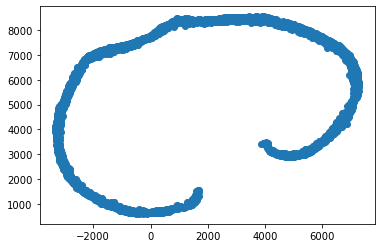

In [8]:
xy_table=pd.read_csv('data/Retina1.csv')
xy_r11=xy_table[(xy_table.RetinaNumber==1) & (xy_table.SectionNumber==1)]
xcoords=xy_r11.Remapped_X.values
ycoords=xy_r11.Remapped_Y.values
plt.figure()
plt.scatter(xcoords, ycoords)

Computing appropriate shift and rotate values and applying them on the input coordinates. 

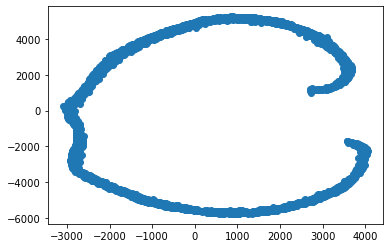

In [9]:
center_shift, theta_shift=coord_transfer(xcoords, ycoords)
center_shift_x=center_shift[0]
center_shift_y=center_shift[1]
xcoords=xcoords-center_shift_x
ycoords=ycoords-center_shift_y
xcoords_rot=(np.cos(theta_shift)*xcoords+np.sin(theta_shift)*ycoords)
ycoords_rot=(np.cos(theta_shift)*ycoords-np.sin(theta_shift)*xcoords)
plt.figure()
plt.scatter(xcoords_rot, ycoords_rot)

Reading three selected cell types to evaluate their joint probability distribution functions. 

In [10]:
xp1=xy_r11[xy_r11.Subtype==1].Remapped_X.values
yp1=xy_r11[xy_r11.Subtype==1].Remapped_Y.values
xp1, yp1, rp1, tp1=coord_translate(xp1, yp1,center_shift ,theta_shift)


xp2=xy_r11[xy_r11.Subtype==2].Remapped_X.values
yp2=xy_r11[xy_r11.Subtype==2].Remapped_Y.values
xp2, yp2, rp2, tp2=coord_translate(xp2, yp2, center_shift ,theta_shift)

xp3=xy_r11[xy_r11.Subtype==3].Remapped_X.values
yp3=xy_r11[xy_r11.Subtype==3].Remapped_Y.values
xp3, yp3, rp3, tp3=coord_translate(xp3, yp3, center_shift,theta_shift)

Generating counterpart random values for the three cell types by shuffling among the whole celltypes. 

In [11]:
idx_rand=np.random.choice(np.arange(len(xcoords_rot)), len(xp1)+len(xp2)+len(xp3), replace=False)
np.random.shuffle(idx_rand)
idx_rand_1=idx_rand[:len(xp1)]
xp1_rand, yp1_rand=xcoords_rot[idx_rand_1], ycoords_rot[idx_rand_1]
idx_rand_2=idx_rand[len(xp1):len(xp1)+len(xp2)]
xp2_rand, yp2_rand=xcoords_rot[idx_rand_2], ycoords_rot[idx_rand_2]
idx_rand_3=idx_rand[len(xp1)+len(xp2):]
xp3_rand, yp3_rand=xcoords_rot[idx_rand_3], ycoords_rot[idx_rand_3]

Plotting the coordinates of the real and randomized celltype locations. 

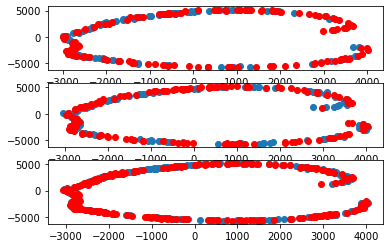

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharey=True)

ax1.scatter(xp1, yp1)
ax1.scatter(xp1_rand, yp1_rand, color='red')

ax2.scatter(xp2, yp2)
ax2.scatter(xp2_rand, yp2_rand, color='red')

ax3.scatter(xp3, yp3)
ax3.scatter(xp3_rand, yp3_rand, color='red')

## Joint Probability  of the Minimum Distance 


Computing joint probabilty of the d11=minimum_distance(celltype_1, celltype_1), d12=minimum_distance(celltype_1, celltype_2), d13=minimum_distance(celltype_1, celltype_3) values. 2 nearest neighbours are used here.  

### Real Data

In [13]:
cpos_1=np.vstack([xp1, yp1]).T
cpos_2=np.vstack([xp2, yp2]).T
cpos_3=np.vstack([xp3, yp3]).T
cpos=[cpos_1, cpos_2, cpos_3]
f3D_Real, pbins=joint_probability(cpos,Num_NNeigh=2)

Plotting the resulted marginal distributions. Multiplied distributions should be approximately the same with joint distributions if the events are independent. 

1

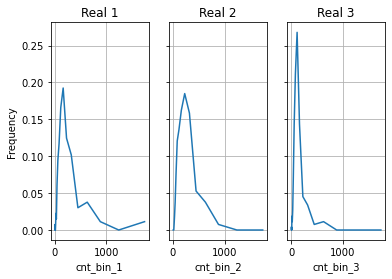

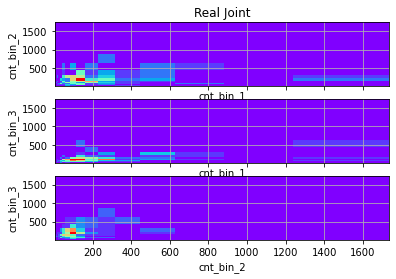

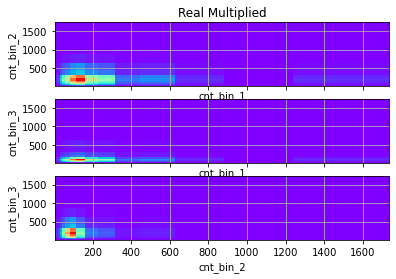

In [14]:
plot_distribution(f3D_Real,pbins, mode='Real')


Computing decomposition of the multivariate information for the input distribution of the three cell types.  

In [15]:
I_Redundancy, I12U, I13U, I_Synergy =pid_compute(f3D_Real)
print('Real Data: \n') 
print('\t Unique information provided by d12 about d11 is: ' ,I12U)
print('\n \t Unique information provided by d13 about d11 is: ' ,I13U)
print('\n \t Redundancy information provided by (d12, d13) about d11 is: ' ,I_Redundancy)
print('\n \t Synergistic information provided by (d12, d13) about d11 is: ' ,I_Synergy)

Real Data: 

	 Unique information provided by d12 about d11 is:  0.048070291417720845

 	 Unique information provided by d13 about d11 is:  0.1300795619414754

 	 Redundancy information provided by (d12, d13) about d11 is:  0.43603845198031177

 	 Synergistic information provided by (d12, d13) about d11 is:  1.0782894117430626


In [16]:
### Random Shuffled Data

In [17]:
cpos_1=np.vstack([xp1_rand, yp1_rand]).T
cpos_2=np.vstack([xp2_rand, yp2_rand]).T
cpos_3=np.vstack([xp3_rand, yp3_rand]).T
cpos=[cpos_1, cpos_2, cpos_3]

f3D_Rand, pbins=joint_probability(cpos, Num_NNeigh=2)

1

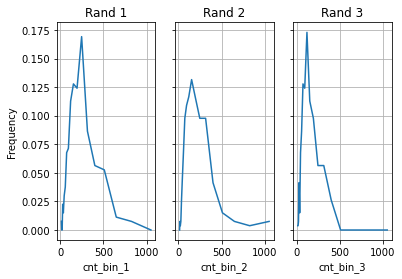

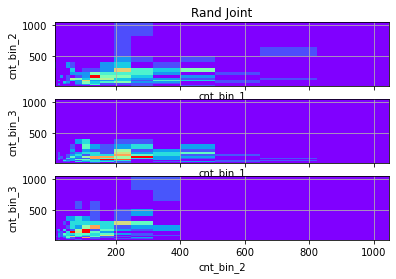

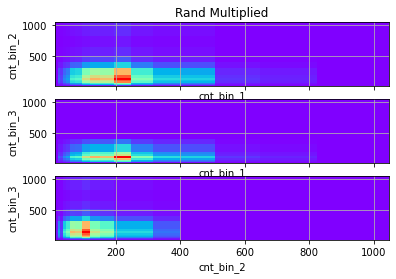

In [18]:
plot_distribution(f3D_Rand,pbins,mode='Rand')


In [19]:
IRand_Redundancy, IRand12U, IRand13U, IRand_Synergy =pid_compute(f3D_Rand)

print('Random Shuffled Data: \n') 
print('\t Unique information provided by d12 about d11 is: ' ,IRand12U)
print('\n \t Unique information provided by d13 about d11 is: ' ,IRand13U)
print('\n \t Redundancy information provided by (d12, d13) about d11 is: ' ,IRand_Redundancy)
print('\n \t Synergistic information provided by (d12, d13) about d11 is: ' ,IRand_Synergy)
 

Random Shuffled Data: 

	 Unique information provided by d12 about d11 is:  0.18059636368946969

 	 Unique information provided by d13 about d11 is:  0.048566329546006315

 	 Redundancy information provided by (d12, d13) about d11 is:  0.48516465019703076

 	 Synergistic information provided by (d12, d13) about d11 is:  1.5103416287021938


## Joint Probability  of the Counted Cell Types in Each Bin

Computing polar coordinates of the input data, and sorting them based on their theta values.

In [20]:
tvalo=np.mod(np.arctan2(ycoords_rot, xcoords_rot), 2*np.pi)
sidx=np.argsort(tvalo)
tvalo=tvalo[sidx]
rvalo=np.sqrt(ycoords_rot**2+xcoords_rot**2)
rvalo=rvalo[sidx]


computing a function between theta values and radius values, based on interpolation

In [21]:
ft=polar_manifold(rvalo, tvalo)
tval_intp=np.linspace(tvalo[0], tvalo[-1], 10*len(tvalo))
r_intp=ft(tval_intp)

Visual demonstration of the bins used for counting cell type numbers. These bins are shifted and averaged in the final computation. 

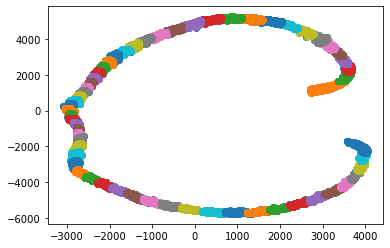

In [22]:
num_slices=60
tvalo_sliced=np.linspace(tvalo[0],tvalo[-1] , num_slices+1)
plt.figure()
plt.scatter(xcoords_rot, ycoords_rot)
for ii in range(len(tvalo_sliced)-1):

    theta_intv=tval_intp[(tval_intp<(tvalo_sliced[ii+1])) & (tval_intp>tvalo_sliced[ii])]
    rval_intv=r_intp[(tval_intp<(tvalo_sliced[ii+1])) & (tval_intp>tvalo_sliced[ii])]
    xrnis_rot_sel=rval_intv*np.cos(theta_intv)
    yrnis_rot_sel=rval_intv*np.sin(theta_intv)
    plt.scatter(xrnis_rot_sel, yrnis_rot_sel)



### Real Data

In [23]:
cpos_1=np.vstack([xp1, yp1]).T
cpos_2=np.vstack([xp2, yp2]).T
cpos_3=np.vstack([xp3, yp3]).T
cpos=[cpos_1, cpos_2, cpos_3]

Joint probability distribution function(pdf) is computed for the bins, the the theta bins are shifted and pdf is computed again for the new structure. The final pdf value is the average pdf among these shifted bins. 

In [24]:
tvalo_slicedT=np.linspace(tvalo[0],tvalo[-1] , num_slices+1)
iter_num=10
theta_inc=(tvalo[-1]-tvalo[0])/(num_slices*iter_num)
theta_start=0
f3D_RealS=0

for iter in range(iter_num):
    chull_vec=[]
    ii=0
    tvalo_sliced=tvalo_slicedT[:-1]+theta_start

    for ii in range(len(tvalo_sliced)-1):

        theta_intv=tval_intp[(tval_intp<(tvalo_sliced[ii+1])) & (tval_intp>tvalo_sliced[ii])]
        rval_intv=r_intp[(tval_intp<(tvalo_sliced[ii+1])) & (tval_intp>tvalo_sliced[ii])]
        xrnis_rot_sel=rval_intv*np.cos(theta_intv)
        yrnis_rot_sel=rval_intv*np.sin(theta_intv)
        
        chull=ConvexHull(np.vstack((xrnis_rot_sel, yrnis_rot_sel)).T)
        chull_vec=np.append(chull_vec, chull.volume)

    f3D_Real,  pbins=joint_probability(cpos,Num_Bins=20, p_bins=tvalo_sliced,svol=chull_vec, mode='bin')
    f3D_RealS=f3D_RealS+ f3D_Real
    theta_start=theta_start+theta_inc
    
f3D_Real=f3D_RealS/np.sum(f3D_RealS)


Plotting the output marginal pdfs. 

1

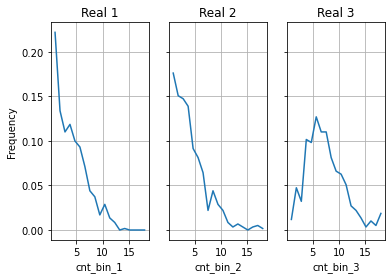

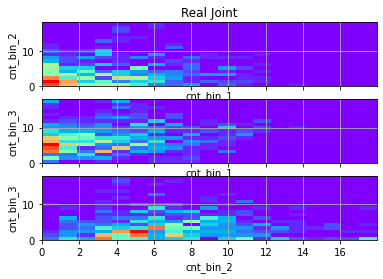

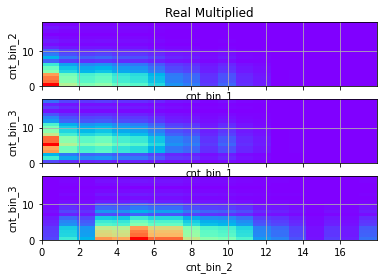

In [25]:
plot_distribution(f3D_Real,pbins, dist_mode='cnt_bin',  mode='Real')


computing PID of the joint multivariate distribution function. 

In [26]:
I_Redundancy, I12U, I13U, I_Synergy = pid_compute(f3D_Real)
print('Real Data: \n') 
print('\t Unique information provided by n2 about n1 is: ' ,I12U)
print('\n \t Unique information provided by n3 about n1 is: ' ,I13U)
print('\n \t Redundancy information provided by (n2, n3) about n1 is: ' ,I_Redundancy)
print('\n \t Synergistic information provided by (n2, n3) about n1 is: ' ,I_Synergy)

Real Data: 

	 Unique information provided by n2 about n1 is:  0.06206351230201618

 	 Unique information provided by n3 about n1 is:  0.08657979129633336

 	 Redundancy information provided by (n2, n3) about n1 is:  0.31805962101765384

 	 Synergistic information provided by (n2, n3) about n1 is:  1.079412123750218


### Random Shuffled Data

The same procedure here is repeated for the random shuffled data. 

In [27]:
cpos_1=np.vstack([xp1_rand, yp1_rand]).T
cpos_2=np.vstack([xp2_rand, yp2_rand]).T
cpos_3=np.vstack([xp3_rand, yp3_rand]).T
cpos=[cpos_1, cpos_2, cpos_3]

theta_start=0
f3D_RandS=0


for iter in range(iter_num):
    chull_vec=[]
    ii=0
    tvalo_sliced=tvalo_slicedT[:-1]+theta_start

    for ii in range(len(tvalo_sliced)-1):

        theta_intv=tval_intp[(tval_intp<(tvalo_sliced[ii+1])) & (tval_intp>tvalo_sliced[ii])]
        rval_intv=r_intp[(tval_intp<(tvalo_sliced[ii+1])) & (tval_intp>tvalo_sliced[ii])]
        xrnis_rot_sel=rval_intv*np.cos(theta_intv)
        yrnis_rot_sel=rval_intv*np.sin(theta_intv)
        
        chull=ConvexHull(np.vstack((xrnis_rot_sel, yrnis_rot_sel)).T)
        chull_vec=np.append(chull_vec, chull.volume)

    f3D_Rand,  pbins=joint_probability(cpos,Num_Bins=20, p_bins=tvalo_sliced,svol=chull_vec, mode='bin')

    f3D_RandS=f3D_RandS+ f3D_Rand
    theta_start=theta_start+theta_inc

1

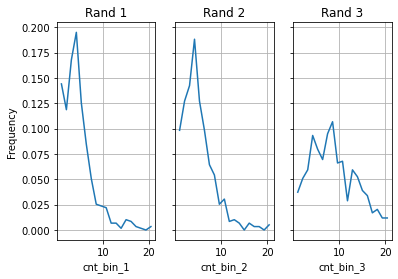

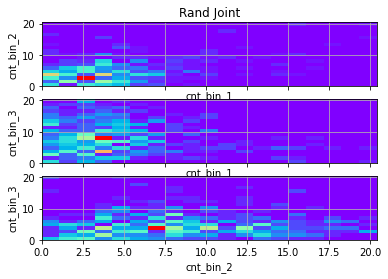

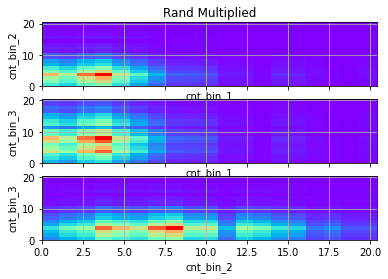

In [28]:
f3D_Rand=f3D_RandS/np.sum(f3D_RandS)
plot_distribution(f3D_Rand,pbins,dist_mode='cnt_bin', mode='Rand')


In [29]:
IRand_Redundancy, IRand12U, IRand13U, IRand_Synergy =pid_compute(f3D_Rand)

print('Random Shuffled Data: \n') 
print('\t Unique information provided by n2 about n1 is: ' ,IRand12U)
print('\n \t Unique information provided by n3 about n1 is: ' ,IRand13U)
print('\n \t Redundancy information provided by (n2, n3) about n1 is: ' ,IRand_Redundancy)
print('\n \t Synergistic information provided by (n2, n3) about n1 is: ' ,IRand_Synergy)
 

Random Shuffled Data: 

	 Unique information provided by n2 about n1 is:  0.16210288023318242

 	 Unique information provided by n3 about n1 is:  0.07627445910627784

 	 Redundancy information provided by (n2, n3) about n1 is:  0.3931775329201387

 	 Synergistic information provided by (n2, n3) about n1 is:  1.1415169962753864
